In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import butter, lfilter , filtfilt
import pandas as pd
import scipy as sp
import os
import sys
import seaborn as sb 
from matplotlib import cm
import ruptures as rpt
import pickle

# Load the data

In [2]:
# Root folder for the data
data_folder = "/Users/nealarohner/Desktop/Data"
#Load the data
subject = 'MR012'
data_file = 'MR012_FM_aligned.mat'
data_file_path = os.path.join(data_folder,data_file)
verbose=1
data_key='data'
amplitudes_key='amplitudes'
fs = 1259.3
dt = 1/fs

In [3]:
root_data_matlab_struct = loadmat(data_file_path,struct_as_record=False,squeeze_me=True)
root_data_re_struct = loadmat(data_file_path)
# Because of the saving from Matlab there are arrays of size 1 containing the data
data_raw = root_data_re_struct[data_key][0][0]
# Not veru pretty but it extracts the electrodes configuration names 
elec_names = root_data_re_struct[data_key].dtype.names
# As well as the recorded muscles names
muscle_and_other_names = data_raw[0][0][0].dtype.names

In [4]:
if verbose>1: print(elec_names)
if verbose>1: print(muscle_and_other_names)

In [5]:
n_elec_configs = len(elec_names)
n_muscles_and_other = len(muscle_and_other_names)

In [ ]:
list_elec_config_dfs = []

for i_elec_config in range(n_elec_configs):       
    elec_config_i = elec_names[i_elec_config]
    if verbose: print(elec_config_i)
    elect_config_i_data = data_raw[elec_config_i][0,0] 
    list_muscle_and_other_elec_config_dfs = []
    list_amplitudes_elec_config=[]
    for i_muscle_and_other in range(n_muscles_and_other):
        muscle_and_other_i = muscle_and_other_names[i_muscle_and_other]
        if verbose: print(muscle_and_other_i)
        muscle_and_other_i_data = elect_config_i_data[muscle_and_other_i]
        n_trials_elec_muscle_and_other_i = np.shape(muscle_and_other_i_data)[-1]
        if verbose: print("N_trials",n_trials_elec_muscle_and_other_i)
        if muscle_and_other_i==amplitudes_key:
            # If it is the special case of amplitudes
            list_amplitudes_elec_config = muscle_and_other_i_data[0,:]      
        else:
            # Not amplitudes
            list_trial_muscle_and_other_elec_config_dfs = []
            for i_trial_elec_muscle_and_other in range(n_trials_elec_muscle_and_other_i):
                if verbose>1: print("trial",i_trial_elec_muscle_and_other)
                trial_muscle_and_other_i_data = muscle_and_other_i_data[0,i_trial_elec_muscle_and_other][0,:]
                n_time_points_trial = len(trial_muscle_and_other_i_data)
                df_trial_muscle_and_other_i_data = pd.DataFrame(data=[[trial_muscle_and_other_i_data]],columns=['Raw'])
                df_trial_muscle_and_other_i_data['Time_points'] = n_time_points_trial
                df_trial_muscle_and_other_i_data['Muscle_or_other'] = muscle_and_other_i
                df_trial_muscle_and_other_i_data['Elec_config'] = elec_config_i
                df_trial_muscle_and_other_i_data['Subject'] = subject
                list_trial_muscle_and_other_elec_config_dfs.append(df_trial_muscle_and_other_i_data)
            if len(list_trial_muscle_and_other_elec_config_dfs)>0:
                df_muscle_or_others = pd.concat(list_trial_muscle_and_other_elec_config_dfs, ignore_index=True)
                df_muscle_or_others.reset_index(inplace=True)
                df_muscle_or_others = df_muscle_or_others.rename(columns = {'index':'Trial_number'})
                list_muscle_and_other_elec_config_dfs.append(df_muscle_or_others)
    # Adds the amplitude to each trial
    n_muscles_and_other_elec_config_dfs = len(list_muscle_and_other_elec_config_dfs)
    for i_muscles_and_other_elec_config_df in range(n_muscles_and_other_elec_config_dfs):
        muscles_and_other_elec_config_df_i = list_muscle_and_other_elec_config_dfs[i_muscles_and_other_elec_config_df]
        muscles_and_other_elec_config_df_i['Amplitudes']=list_amplitudes_elec_config
        list_muscle_and_other_elec_config_dfs[i_muscles_and_other_elec_config_df] = muscles_and_other_elec_config_df_i
    if len(list_muscle_and_other_elec_config_dfs)>0:
        df_elec_config = pd.concat(list_muscle_and_other_elec_config_dfs, ignore_index=True)
        list_elec_config_dfs.append(df_elec_config)
if len(list_elec_config_dfs)>0:
    df_subject = pd.concat(list_elec_config_dfs, ignore_index=True)

In [7]:
n_rows_to_display = 5
pd.set_option('display.max_rows', n_rows_to_display)

In [8]:
df_subject.head(n_rows_to_display)

,Trial_number,Raw,Time_points,Muscle_or_other,Elec_config,Subject,Amplitudes
0,0,[-1],1,LST,Elec01_,MR012,0.5
1,1,[-1],1,LST,Elec01_,MR012,0.5
2,2,[-1],1,LST,Elec01_,MR012,0.5
3,3,[-1],1,LST,Elec01_,MR012,0.5
4,4,[-1],1,LST,Elec01_,MR012,0.5


Now with the dataframe shaped, we can proceed into expanding it (creating the entries with the filtered data, etc... 
In this way will be able to generate any desired plots just querying the dataframe.

In [9]:
#### Creating a Value column instead of cells of arrays
##### Beware - very time consuming if applied to all the data-frame.
def form_data_frame_with_values(df_with_arrays,verbose=0):
    """ 
    Goes through all the trials of the dataframe and extracts all its values
    """
   
    list_dfs_with_values=[]
    length_df_arrays = len(df_with_arrays)
    for i_row in range(length_df_arrays):
        row_i = df_with_arrays.iloc[i_row]
        length_trial_row_i = int(row_i['Time_points'])
        values_raw_trial_row_i = row_i['Raw']
        row_i_no_raw_trial = row_i.drop(['Raw'])
        list_values_trial_row_i_dfs = []
        for i_trial_row_i in range(length_trial_row_i):
            value_i_raw_trial_row_i = values_raw_trial_row_i[i_trial_row_i]
            row_i_no_raw_trial_copy = row_i_no_raw_trial.copy()
            row_i_no_raw_trial_copy['Value'] = value_i_raw_trial_row_i
            row_i_no_raw_trial_copy['time_ind'] = i_trial_row_i
            df_row_i_no_raw_trial_copy = pd.DataFrame(row_i_no_raw_trial_copy).transpose()
            list_values_trial_row_i_dfs.append(df_row_i_no_raw_trial_copy)
        df_trial_row_i = pd.concat(list_values_trial_row_i_dfs, ignore_index=True)
        list_dfs_with_values.append(df_trial_row_i)
    df_with_values = pd.concat(list_dfs_with_values, ignore_index=True)
    return df_with_values

In [10]:
# Saving the data_frame
def save_data_frame(data_folder,file_name,df_to_save,verbose=0):
    """ Vaces the input dataframe as a csv in the given folder."""
    file_name_for_saving_the_raw_df = file_name
    raw_data_file_path = os.path.join(data_folder,file_name_for_saving_the_raw_df)
    df_to_save.to_csv(raw_data_file_path)
    #path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, date_format=None, doublequote=True, escapechar=None, decimal='.', errors='strict', storage_options=None)

### Plotting the raw data

In [11]:


def plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i, muscle_i_elec_i, time_series_key='Raw',time_points_key='Time_points',init_t_plot = 0,end_t_plot = -1, save_flag=0,save_folder='tmp'):
    """Simplest plotting function for a time serie stored in the dataframe"""
    print(f"We are printing {time_series_key}")
    n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
    plt.figure(figsize = (10,5))
    offset = 0
    ax = plt.axes()
    for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
        offset += 1.0
        trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
        time_points_trial_i=int(trial_i_elec_i_muscle_i[time_points_key])
        time_array = dt*np.arange(1,time_points_trial_i+1)
        values=[]
        if time_series_key=='Raw':
            values = trial_i_elec_i_muscle_i[time_series_key]
        else:
            values = trial_i_elec_i_muscle_i[time_series_key]#[0]
        plt.plot(time_array[init_t_plot:end_t_plot],values[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trials_elec_i_muscle_i/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
    plt.xlabel('Time [s]', fontsize=10),
    plt.ylabel('Trial number', fontsize=10),
    plt.title(elec_i+"-"+muscle_i_elec_i, fontsize=20)
    if save_flag:
        data_file = time_series_key+"_"+elec_i+muscle_i_elec_i+'.png'
        data_file_path = os.path.join(save_folder,data_file)
        plt.savefig(data_file_path, transparent = "True", bbox_inches='tight')

In [12]:
time_series_key='Raw'
time_points_key='Time_points'
init_t_plot = 100
end_t_plot = 300

In [13]:


def plot_trial_elec_i_muscle_i_arifact_free(df_subject_no_empty_elec_i_muscle_i,elec_i, muscle_i_elec_i, time_series_key='TS_arts_1',time_points_key='Time_points_arts_1',init_t_plot = 0,end_t_plot = -1, save_flag=0,save_folder='tmp'):
    """Simplest plotting function for a time serie stored in the dataframe"""
    time_series_key='TS_arts_1'
    time_points_key='Time_points_arts_1'
    print(f"We are printing {time_series_key}")
    n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
    print(f" n_trials_elec_i_muscle_i: {n_trials_elec_i_muscle_i}")
    plt.figure(figsize = (10,5))
    offset = 0
    ax = plt.axes()
    for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
        offset += 1.0
        trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
        time_points_trial_i=int(trial_i_elec_i_muscle_i[time_points_key])
        time_array = dt*np.arange(1,time_points_trial_i+1)
        values=[]
        if time_series_key=='TS_arts_1':
            values = trial_i_elec_i_muscle_i[time_series_key]
        else:
            values = trial_i_elec_i_muscle_i[time_series_key]#[0]
        plt.plot(time_array[init_t_plot:end_t_plot],values[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trials_elec_i_muscle_i/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
    plt.xlabel('Time [s]', fontsize=10),
    plt.ylabel('Trial number', fontsize=10),
    plt.title(str(elec_i)+"-"+str(muscle_i_elec_i)+"artifact_freer_data", fontsize=20)
    if save_flag:
        data_file = time_series_key+"_"+elec_i+muscle_i_elec_i+'.png'
        data_file_path = os.path.join(save_folder,data_file)
        plt.savefig(data_file_path, transparent = "True", bbox_inches='tight')

In [14]:
# Only keeping the ones that got data
df_subject_no_empty = df_subject.where(df_subject['Time_points']>1)
df_subject_no_empty.dropna(inplace=True)

In [15]:
save_flag=1
subject_plots_folder_name=subject+'_plots'
save_folder = os.path.join(data_folder,subject_plots_folder_name,"Raw_tinit_100_tend_300")
os.makedirs(save_folder,exist_ok=True)

In [17]:
#make list of elec_muscle eg 01_06 each one will be one object (eg. same as when we graph the all the trials)
list_elecs = df_subject_no_empty['Elec_config'].unique()
n_list_elecs = len(list_elecs)
list_muscle_or_other_elec_i = df_subject_no_empty['Muscle_or_other'].unique()
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
list_elec_i_a_muslce_i=[]
for i_elec in range(n_list_elecs):
    for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
        number=str(i_elec)+"_"+str(i_muscle_or_other_elec_i)
        list_elec_i_a_muslce_i.append(number)
print(list_elec_i_a_muslce_i)




['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '0_10', '0_11', '0_12', '0_13', '0_14', '1_0', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '1_8', '1_9', '1_10', '1_11', '1_12', '1_13', '1_14', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '2_7', '2_8', '2_9', '2_10', '2_11', '2_12', '2_13', '2_14', '3_0', '3_1', '3_2', '3_3', '3_4', '3_5', '3_6', '3_7', '3_8', '3_9', '3_10', '3_11', '3_12', '3_13', '3_14', '4_0', '4_1', '4_2', '4_3', '4_4', '4_5', '4_6', '4_7', '4_8', '4_9', '4_10', '4_11', '4_12', '4_13', '4_14', '5_0', '5_1', '5_2', '5_3', '5_4', '5_5', '5_6', '5_7', '5_8', '5_9', '5_10', '5_11', '5_12', '5_13', '5_14', '6_0', '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', '6_7', '6_8', '6_9', '6_10', '6_11', '6_12', '6_13', '6_14', '7_0', '7_1', '7_2', '7_3', '7_4', '7_5', '7_6', '7_7', '7_8', '7_9', '7_10', '7_11', '7_12', '7_13', '7_14', '8_0', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '8_7', '8_8', '8_9', '8_10', '8_11', '8_12', '8_13', '8_14', '9_0', '9

In [ ]:
#class to quicker acess the plots

#1. make list of elec_muscle eg 01_06 each one will be one object (eg. same as when we graph the all the trials) 



list_elecs = df_subject_no_empty['Elec_config'].unique() #Elec01_, Elec02_, Elec03_, 
n_list_elecs = len(list_elecs) #
list_muscle_or_other_elec_i = df_subject_no_empty['Muscle_or_other'].unique() #Vlat, LST, ..
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
list_elec_i_a_muslce_i=[]


    
#3. Set the attributes
#4. Goal is to chose an electrode and a muscle and see all the trials and the corrected data

class DfSubject:
    def __init__(self, elec_i, muscle_i):
        self.Elec_config=list_elecs[elec_i]
        print (self.Elec_config)
        self.Muscle_or_other=list_muscle_or_other_elec_i[muscle_i]
        print(self.Muscle_or_other)
        self.Trial_number= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Trial_number"]
        self.Raw= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Raw"]
        self.Raw.index=self.Trial_number
        self.Time_points= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Time_points"]
        self.Amplitudes= df_subject_no_empty[(df_subject_no_empty["Elec_config"]==self.Elec_config)& (df_subject_no_empty["Muscle_or_other"]== self.Muscle_or_other)]["Amplitudes"]
        self.TS_arts_1="$"
        # self.TS_arts_1.index=self.Trial_number
        self.Time_points_arts_1=-1

#         df_subject_no_empty['TS_arts_filt_rect_meaned']="$"
# df_subject_no_empty['Time_points_arts_filt_rect_meaned']=-1
# df_subject_no_empty['TS_arts_1'] ="$"
# df_subject_no_empty['Time_points_arts_1'] =-1
# df_subject_no_empty['TS_arts_2'] ="$"
# df_subject_no_empty['Time_points_arts_2']=-1
# df_subject_no_empty['TS_arts_filt'] ="$"
# df_subject_no_empty['Time_points_arts_filt'] =-1
# df_subject_no_empty['TS_arts_filt_rect'] ="$"
# df_subject_no_empty['Time_points_arts_filt_rect']=-1

pData = {}
for elec_i in range(n_list_elecs):
    for muscle_i in range(n_muscle_or_other_elec_i):
        pData[f"{elec_i}_{muscle_i}"] = DfSubject(elec_i, muscle_i)
        



In [ ]:
#Access a specific trial in the df
# print(pData["3_5"].Raw)
# len(pData["3_5"].Raw)

# plt.plot(pData["3_5"].Raw)
# pData["3_5"].TS_arts_1[19] = pData["3_5"].Raw[19]
# pData["3_5"].Time_points
# time_points_trial_i=[int(i)for i in pData["3_5"].Time_points]
pData["3_5"].TS_arts_1

In [28]:
###Plot all the graphs
#to run set run=1
run=1
if run==1:
    list_elecs = df_subject_no_empty['Elec_config'].unique()
    n_list_elecs = len(list_elecs)
    for i_elec in range(n_list_elecs):
        elec_i = list_elecs[i_elec]
        df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
        df_subject_no_empty_elec_i.dropna(inplace=True)
        list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
        n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
        for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
            muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
            df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
            df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
            # plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)
            

## Filtering the signal

Following [Rowald, Komi, Demesmeaker et al. 2022](https://www.nature.com/articles/s41591-021-01663-5#Sec14):
```
Analysis of lower limb muscle activity

The electromyographic activity from lower limb muscles was processed according to SENIAM (Surface Electromyography for the Non-Invasive Assessment of Muscles) standards for electromyographic recordings. All displayed electromyographic activities during walking were band-pass filtered between 10 and 450 Hz (fourth-order Butterworth filter). A moving average of the rectified electromyographic signal within a centered 250-ms time window was used to generate normalized electromyographic envelopes for quantification.
```
Even it is walking we can consider applying the same:
1. Band-pass 10-450 Hz (fourth-order Butterworth filter).
2. Rectify (absolute value).
3. Average 250 ms time window average filter.

In [64]:
high_band = 450
low_band = 10
order_filter = 4
average_window_filter_seconds=0.005

In [65]:
# Filtering preparation
butter_sos_filter = sp.signal.butter(N=order_filter,Wn=[low_band,high_band],btype='bandpass',output='sos',fs=fs)
average_window_filter_size=int(np.ceil(average_window_filter_seconds/dt))

In [66]:
# We get the last point in time
last_t_point = int(df_subject_no_empty['Time_points'].max())
# We take some before to define our end of array
n_points_before_last_t_pont = 4

In [67]:
init_t_plot = 0
end_t_plot = last_t_point-n_points_before_last_t_pont

Our experiments showed that there are a number of artefacts. And that the average 250 ms time window average filter was smoothing the signal to the point of suppressing it. 
We changed our pipeline to:

1. Find the artefacts that keep repeating all over the signal.
2. Do pattern matching on the signals using a simple cross-validation threshold to find the location of these artefacts on signals.
3. Replace by 0s wherever these artefacts are found.
4. Find high transients and replace these chunks between these high transients with 0s using the `ruptures` library, implemented in [Selective review of offline change point detection methods](https://doi.org/10.1016/j.sigpro.2019.107299).

Then we proceed with:

5. Band-pass 10-450 Hz (fourth-order Butterworth filter).
6. Rectify (absolute value).
7. Average 5 ms time window average filter.

After a couple of tests, 250ms is way too much. 5 ms seems to be reasonable

# Find Artifacts

### First Artifact

LVLat

4554     9.0
4555    10.0
        ... 
4612    67.0
4613    68.0
Name: Trial_number, Length: 59, dtype: float64


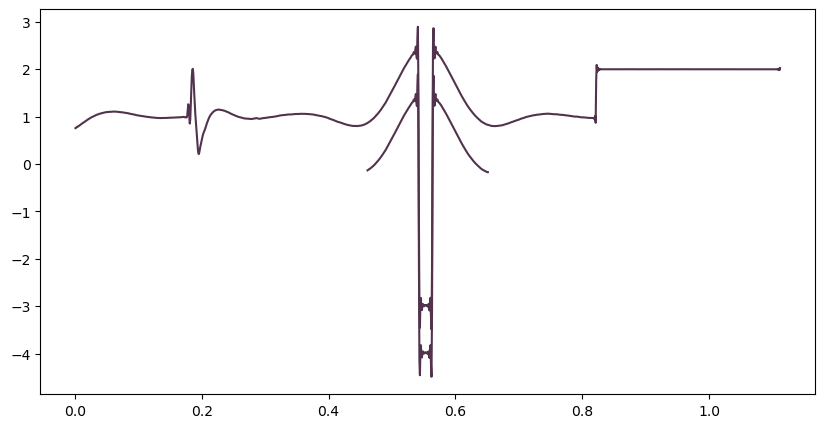

In [132]:
#Plot artifact one
i_elec_artifact=3
i_muscle_i_elec_artifact=5
i_trial_i_muscle_i_elec_artifact=19
init_t_artifact=580
end_t_artifact=820
artifact_number=1
elec_i = list_elecs[i_elec_artifact]
df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i) #df with only sepc electrode
df_subject_no_empty_elec_i.dropna(inplace=True) 
list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique() #Returns the sorted unique elements of an array
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_i_elec_artifact]
print(muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
print()
n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trial_i_muscle_i_elec_artifact]
print(df_subject_no_empty_elec_i_muscle_i["Trial_number"])
time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points']) #number of time points
#evt change dt to 1/time_points_trial_i
time_array = dt*np.arange(1,time_points_trial_i+1) #dt = 1/fs sampling interval( abhängig vom EMG)
trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
plt.figure(figsize = (10,5))
offset = 1.0
plt.plot(time_array[init_t_plot:end_t_plot],trial_i_muscle_i_elec_i_raw[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) #the whole trial
plt.plot(time_array[init_t_artifact:end_t_artifact],trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact], linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) #just the time series of the artifact
artifact_time_serie = trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact]

    

In [ ]:
print(f"artifact_number:{artifact_number}" )
subject_plots_folder_name=subject+'_plots'
save_folder = os.path.join(data_folder,subject_plots_folder_name)
save_file = subject+"artf"+str(artifact_number)+"_"+str(i_elec_artifact)+"_"+str(i_muscle_i_elec_artifact)+"_"+str(i_trial_i_muscle_i_elec_artifact)+"_"+str(init_t_artifact)+"-"+str(end_t_artifact)+".csv"
save_file_path = os.path.join(save_folder,save_file)
np.savetxt(save_file_path, artifact_time_serie, delimiter=',')

artifact_number:1


In [97]:
# Find the max cross_corr overall for normalization
max_corr_val = -99 #why so high? isnt correlation normally from 0 to 1?
for i_elec in range(n_list_elecs):
    elec_i = list_elecs[i_elec]
    df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
    df_subject_no_empty_elec_i.dropna(inplace=True)
    list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
    n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
    for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
        muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
        df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
        df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
        n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
        for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
            trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
            trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
            corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie) # saves the correlation betweeen the artifact and the EMG 
            corr_abs = np.abs(corr)  # take abs value of correlation, since we search for pos and neg correlation
            if np.max(corr_abs) > max_corr_val:  #why such a big number?
                max_corr_val = np.max(corr_abs) 


#now plot the new code?

In [112]:
th_corr = 0.6
n_t_points_before = 0
n_t_points_after = len(artifact_time_serie)

In [113]:
min_size_transients = 100
beta_value_transients = 1
indices_to_go_back_and_zero = 50
transient_index=-2
end_index_zero_transients=-1

In [ ]:
#try correlation finding only on one artifact

time_points_trial_i=[int(i)for i in pData["3_5"].Time_points]

trial_i_muscle_i_elec_i_raw = pData["3_5"].Raw[19]
trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
corr_abs = np.abs(corr)
corr_abs /= max_corr_val
indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
for i_index_to_delete in range(len(indices_to_delete)):
    index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
    trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    

pData["3_5"].TS_arts_1[19] = trial_i_muscle_i_elec_i_raw_to_zero
pData["3_5"].Time_points_arts_1= len(trial_i_muscle_i_elec_i_raw_to_zero)

# trial_i_elec_i_muscle_i_trial_index = trial_i_elec_i_muscle_i.name
# time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points'])
# trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i["Raw"]
# trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
# corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
# lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
# corr_abs = np.abs(corr)
# corr_abs /= max_corr_val
# indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
# for i_index_to_delete in range(len(indices_to_delete)):
#     index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
#     trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    
# trial_i_elec_i_muscle_i['TS_arts_1']
# df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_1'] = trial_i_muscle_i_elec_i_raw_to_zero
# df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_1'] = len(trial_i_muscle_i_elec_i_raw_to_zero)

In [ ]:

#plot the raw and the corrected veriosn
plt.figure(figsize = (10,5))
plt.xlabel("Time_points")
plt.ylabel("EMG_signal")
plt.plot(pData["3_5"].Raw[19], linewidth = 1.5, label="Raw_data") #the whole trial
plt.plot(pData["3_5"].TS_arts_1[19], linewidth = 1.5, label="artifact_reduced") #the whole trial
plt.legend()


# plt.figure(figsize = (10,5))
# plt.xlabel("Time_points")
# plt.ylabel("EMG_signal")
# plt.plot(trial_i_elec_i_muscle_i['Raw'], linewidth = 1.5, label="Raw_data") #the whole trial
# plt.plot(trial_i_elec_i_muscle_i['TS_arts_1'], linewidth = 1.5, label="artifact_reduced") #the whole trial
# plt.legend()



We go now through the data and create the new time-series

In [ ]:
# Add the missing columns
df_subject_no_empty['TS_arts_filt_rect_meaned']="$"
df_subject_no_empty['Time_points_arts_filt_rect_meaned']=-1
df_subject_no_empty['TS_arts_1'] ="$"
df_subject_no_empty['Time_points_arts_1'] =-1
df_subject_no_empty['TS_arts_2'] ="$"
df_subject_no_empty['Time_points_arts_2']=-1
df_subject_no_empty['TS_arts_filt'] ="$"
df_subject_no_empty['Time_points_arts_filt'] =-1
df_subject_no_empty['TS_arts_filt_rect'] ="$"
df_subject_no_empty['Time_points_arts_filt_rect']=-1
# Loop through the elecs
for i_elec in range(0,n_list_elecs):
    elec_i = list_elecs[i_elec]
    df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
    df_subject_no_empty_elec_i.dropna(inplace=True)
    list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
    n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
    # Loop through the muscles of the elec_i
    for i_muscle_or_other_elec_i in range(0,n_muscle_or_other_elec_i):
        muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
        df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
        df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
        # Loop through the trials of the muscle_i of the elec_i
        n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
        for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
            trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
            trial_i_elec_i_muscle_i_trial_index = trial_i_elec_i_muscle_i.name
            time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points'])
            trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i["Raw"]
            trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
            corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)
            lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
            corr_abs = np.abs(corr)
            corr_abs /= max_corr_val
            indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #What is the goal of that??
            for i_index_to_delete in range(len(indices_to_delete)):
                index_to_delete_i = indices_to_delete[i_index_to_delete]
                trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0
            # algo_c = rpt.KernelCPD(kernel="rbf", min_size=min_size_transients).fit(trial_i_muscle_i_elec_i_raw) 
            # penalty_value = beta_value_transients  # beta
            # bkps_c = algo_c.predict(pen=penalty_value)
            # putting_to_zero_index = bkps_c[transient_index]-indices_to_go_back_and_zero
            # trial_i_muscle_i_elec_i_raw_to_zero_bis = trial_i_muscle_i_elec_i_raw_to_zero.copy()
            # index_for_zero = int(putting_to_zero_index)
            # trial_i_muscle_i_elec_i_raw_to_zero_bis[index_for_zero:end_index_zero_transients] = 0
            # Saving in the dataframe
            df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_1'] = trial_i_muscle_i_elec_i_raw_to_zero
            df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_1'] = len(trial_i_muscle_i_elec_i_raw_to_zero)
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_2'] = trial_i_muscle_i_elec_i_raw_to_zero_bis
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_2'] = len(trial_i_muscle_i_elec_i_raw_to_zero_bis)
            # trial_i_muscle_i_elec_i_filtered = sp.signal.sosfilt(butter_sos_filter, trial_i_muscle_i_elec_i_raw_to_zero_bis)
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_filt'] = trial_i_muscle_i_elec_i_filtered
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_filt'] = len(trial_i_muscle_i_elec_i_filtered)
            # trial_i_muscle_i_elec_i_filtered_rectified = np.abs(trial_i_muscle_i_elec_i_filtered)
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_filt_rect'] = trial_i_muscle_i_elec_i_filtered_rectified
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_filt_rect'] = len(trial_i_muscle_i_elec_i_filtered_rectified)
            # trial_i_muscle_i_elec_i_filtered_rectified_meaned = sp.ndimage.filters.uniform_filter1d(trial_i_muscle_i_elec_i_filtered_rectified,size=average_window_filter_size)
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_filt_rect_meaned'] = trial_i_muscle_i_elec_i_filtered_rectified_meaned
            # df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_filt_rect_meaned'] = len(trial_i_muscle_i_elec_i_filtered_rectified_meaned)            

In [ ]:
plt.figure(figsize = (10,5))
plt.xlabel("Time_points")
plt.ylabel("EMG_signal")
plt.plot(trial_i_elec_i_muscle_i['Raw'], linewidth = 1.5, label="Raw_data") #the whole trial
plt.plot(trial_i_elec_i_muscle_i['TS_arts_1'], linewidth = 1.5, label="artifact_reduced") #the whole trial
plt.legend()

### Second artifact

LMG

1689     9.0
1690    10.0
        ... 
1762    82.0
1763    83.0
Name: Trial_number, Length: 74, dtype: float64


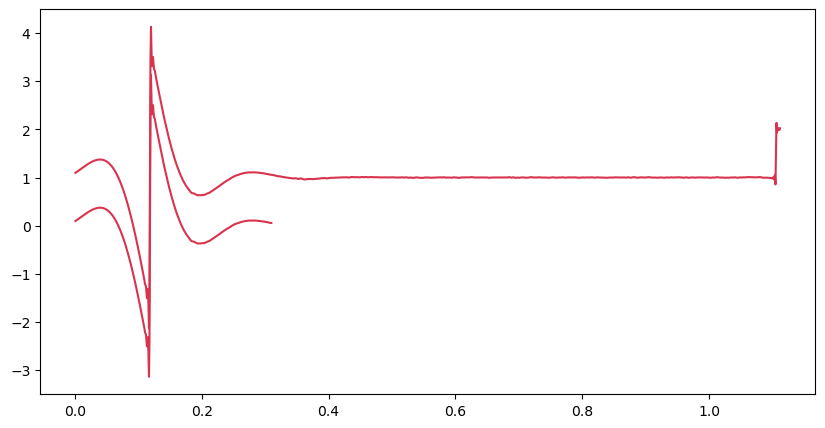

In [127]:
# #Plot artifact two
# plot_artifact(i_elec_artifact=1,i_muscle_i_elec_artifact=3,i_trial_i_muscle_i_elec_artifact=63,init_t_artifact=0,end_t_artifact=390, artifact_number=2)

i_elec_artifact=1
i_muscle_i_elec_artifact=3
i_trial_i_muscle_i_elec_artifact=63
init_t_artifact=0
end_t_artifact=390
artifact_number=2
elec_i = list_elecs[i_elec_artifact]
df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i) #df with only sepc electrode
df_subject_no_empty_elec_i.dropna(inplace=True) 
list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique() #Returns the sorted unique elements of an array
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_i_elec_artifact]
print(muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
print()
n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trial_i_muscle_i_elec_artifact]
print(df_subject_no_empty_elec_i_muscle_i["Trial_number"])
time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points']) #number of time points
#evt change dt to 1/time_points_trial_i
time_array = dt*np.arange(1,time_points_trial_i+1) #dt = 1/fs sampling interval( abhängig vom EMG)
trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
plt.figure(figsize = (10,5))
offset = 1.0

plt.plot(time_array[init_t_plot:end_t_plot],trial_i_muscle_i_elec_i_raw[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
plt.plot(time_array[init_t_artifact:end_t_artifact],trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact], linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
artifact_time_serie = trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact]

In [121]:
#save artifact
print(f"artifact_number:{artifact_number}" )
subject_plots_folder_name=subject+'_plots'
save_folder = os.path.join(data_folder,subject_plots_folder_name)
save_file = subject+"artf"+str(artifact_number)+"_"+str(i_elec_artifact)+"_"+str(i_muscle_i_elec_artifact)+"_"+str(i_trial_i_muscle_i_elec_artifact)+"_"+str(init_t_artifact)+"-"+str(end_t_artifact)+".csv"
save_file_path = os.path.join(save_folder,save_file)
np.savetxt(save_file_path, artifact_time_serie, delimiter=',')

artifact_number:2


In [122]:
# Find the max cross_corr overall for normalization
max_corr_val = -99 #why so high? isnt correlation normally from 0 to 1?
for i_elec in range(n_list_elecs):
    elec_i = list_elecs[i_elec]
    df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
    df_subject_no_empty_elec_i.dropna(inplace=True)
    list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
    n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
    for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
        muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
        df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
        df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
        n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
        for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
            trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
            trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
            corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie) # saves the correlation betweeen the artifact and the EMG 
            corr_abs = np.abs(corr)  # take abs value of correlation, since we search for pos and neg correlation
            if np.max(corr_abs) > max_corr_val:  #why such a big number?
                max_corr_val = np.max(corr_abs) 

In [123]:
#try correlation finding only on one artifact

time_points_trial_i=[int(i)for i in pData["1_3"].Time_points]

trial_i_muscle_i_elec_i_raw = pData["1_3"].Raw[63]
trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
corr_abs = np.abs(corr)
corr_abs /= max_corr_val
indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
for i_index_to_delete in range(len(indices_to_delete)):
    index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
    trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    

pData["1_3"].TS_arts_1[63] = trial_i_muscle_i_elec_i_raw_to_zero

# pData["3_5"].Time_points_arts_1[19]= len(trial_i_muscle_i_elec_i_raw_to_zero)

# trial_i_elec_i_muscle_i_trial_index = trial_i_elec_i_muscle_i.name
# time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points'])
# trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i["Raw"]
# trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
# corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
# lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
# corr_abs = np.abs(corr)
# corr_abs /= max_corr_val
# indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
# for i_index_to_delete in range(len(indices_to_delete)):
#     index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
#     trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    
# trial_i_elec_i_muscle_i['TS_arts_1']
# df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'TS_arts_1'] = trial_i_muscle_i_elec_i_raw_to_zero
# df_subject_no_empty.at[trial_i_elec_i_muscle_i_trial_index,'Time_points_arts_1'] = len(trial_i_muscle_i_elec_i_raw_to_zero)

In [ ]:
#plot the raw and the corrected veriosn
plt.figure(figsize = (10,5))
plt.xlabel("Time_points")
plt.ylabel("EMG_signal")
plt.ylim(-3, 4)
plt.plot(pData["1_3"].Raw[63], linewidth = 1.5, label="Raw_data") #the whole trial
plt.plot(pData["1_3"].TS_arts_1[63], linewidth = 1.5, label="artifact_reduced") #the whole trial
plt.legend()

### Third artifact

In [ ]:
# #plot third artifact
# plot_artifact(i_elec_artifact=3, i_muscle_i_elec_artifact=7, i_trial_i_muscle_i_elec_artifact=27, init_t_artifact=100, end_t_artifact=590, artifact_number=3)


i_elec_artifact=3
i_muscle_i_elec_artifact=7
i_trial_i_muscle_i_elec_artifact=27
init_t_artifact=100
end_t_artifact=590
artifact_number=3
elec_i = list_elecs[i_elec_artifact]
df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i) #df with only sepc electrode
df_subject_no_empty_elec_i.dropna(inplace=True) 
list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique() #Returns the sorted unique elements of an array
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_i_elec_artifact]
print(muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
print()
n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trial_i_muscle_i_elec_artifact]
print(df_subject_no_empty_elec_i_muscle_i["Trial_number"])
time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points']) #number of time points
#evt change dt to 1/time_points_trial_i
time_array = dt*np.arange(1,time_points_trial_i+1) #dt = 1/fs sampling interval( abhängig vom EMG)
trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
plt.figure(figsize = (10,5))
offset = 1.0

plt.plot(time_array[init_t_plot:end_t_plot],trial_i_muscle_i_elec_i_raw[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
plt.plot(time_array[init_t_artifact:end_t_artifact],trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact], linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
artifact_time_serie = trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact]

In [ ]:
#save artifact
print(f"artifact_number:{artifact_number}" )
subject_plots_folder_name=subject+'_plots'
save_folder = os.path.join(data_folder,subject_plots_folder_name)
save_file = subject+"artf"+str(artifact_number)+"_"+str(i_elec_artifact)+"_"+str(i_muscle_i_elec_artifact)+"_"+str(i_trial_i_muscle_i_elec_artifact)+"_"+str(init_t_artifact)+"-"+str(end_t_artifact)+".csv"
save_file_path = os.path.join(save_folder,save_file)
np.savetxt(save_file_path, artifact_time_serie, delimiter=',')

artifact_number:2


In [ ]:
# Find the max cross_corr overall for normalization
max_corr_val = -99 #why so high? isnt correlation normally from 0 to 1?
for i_elec in range(n_list_elecs):
    elec_i = list_elecs[i_elec]
    df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
    df_subject_no_empty_elec_i.dropna(inplace=True)
    list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
    n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
    for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
        muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
        df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
        df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
        n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
        for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
            trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
            trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
            corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie) # saves the correlation betweeen the artifact and the EMG 
            corr_abs = np.abs(corr)  # take abs value of correlation, since we search for pos and neg correlation
            if np.max(corr_abs) > max_corr_val:  #why such a big number?
                max_corr_val = np.max(corr_abs) 

In [135]:
#try correlation finding only on one artifact
time_points_trial_i=[int(i)for i in pData["3_7"].Time_points]

trial_i_muscle_i_elec_i_raw = pData["3_7"].Raw[27]
trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
corr_abs = np.abs(corr)
corr_abs /= max_corr_val
indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
for i_index_to_delete in range(len(indices_to_delete)):
    index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
    trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    

pData["3_7"].TS_arts_1 = trial_i_muscle_i_elec_i_raw_to_zero
pData["3_7"].Time_points_arts_1= len(trial_i_muscle_i_elec_i_raw_to_zero)

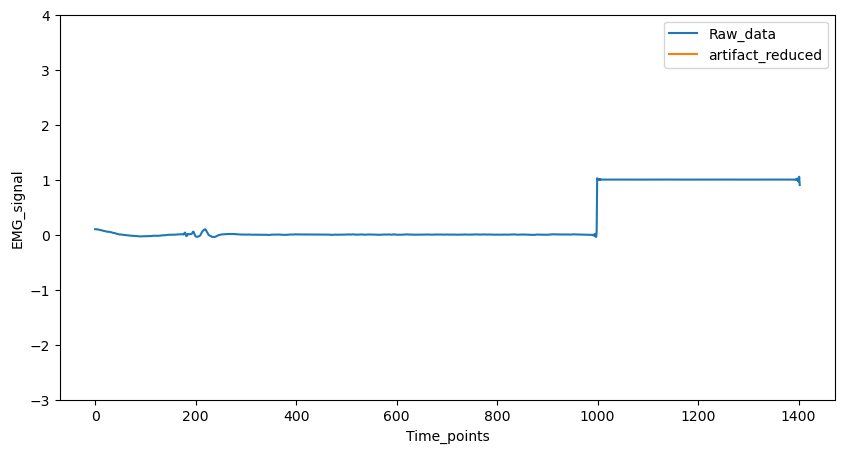

In [137]:
#plot the raw and the corrected veriosn
plt.figure(figsize = (10,5))
plt.xlabel("Time_points")
plt.ylabel("EMG_signal")
plt.ylim(-3, 4)
plt.plot(pData["3_7"].Raw[27], linewidth = 1.5, label="Raw_data") #the whole trial
plt.plot(pData["3_7"].TS_arts_1[27], linewidth = 1.5, label="artifact_reduced") #the whole trial
plt.legend()

### Fourth artifact

RTA

2284     9.0
2285    10.0
        ... 
2357    82.0
2358    83.0
Name: Trial_number, Length: 74, dtype: float64


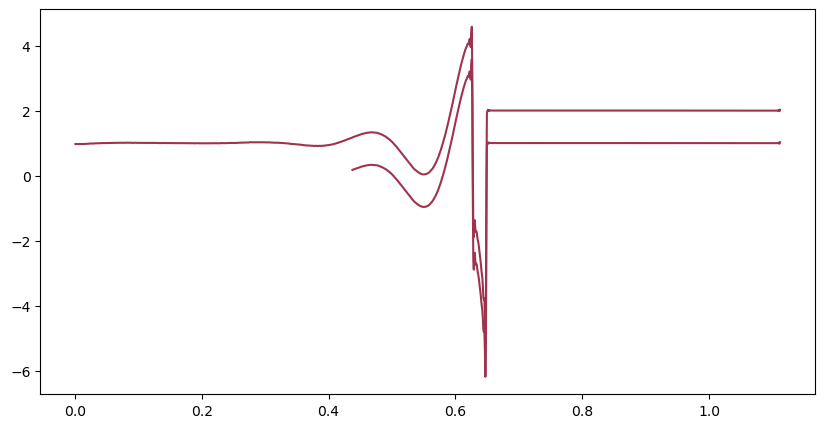

In [138]:
#plot fourth artifact
# plot_artifact(i_elec_artifact=1, i_muscle_i_elec_artifact=10, i_trial_i_muscle_i_elec_artifact=46, init_t_artifact=550, end_t_artifact=1400, artifact_number=4)

i_elec_artifact=1
i_muscle_i_elec_artifact=10
i_trial_i_muscle_i_elec_artifact=46
init_t_artifact=550
end_t_artifact=1400
artifact_number=4
elec_i = list_elecs[i_elec_artifact]
df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i) #df with only sepc electrode
df_subject_no_empty_elec_i.dropna(inplace=True) 
list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique() #Returns the sorted unique elements of an array
n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_i_elec_artifact]
print(muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
print()
n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trial_i_muscle_i_elec_artifact]
print(df_subject_no_empty_elec_i_muscle_i["Trial_number"])
time_points_trial_i=int(trial_i_elec_i_muscle_i['Time_points']) #number of time points
#evt change dt to 1/time_points_trial_i
time_array = dt*np.arange(1,time_points_trial_i+1) #dt = 1/fs sampling interval( abhängig vom EMG)
trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
plt.figure(figsize = (10,5))
offset = 1.0

plt.plot(time_array[init_t_plot:end_t_plot],trial_i_muscle_i_elec_i_raw[init_t_plot:end_t_plot]+ offset, linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
plt.plot(time_array[init_t_artifact:end_t_artifact],trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact], linewidth = 1.5, color = (i_trial_i_muscle_i_elec_artifact/n_trials_elec_i_muscle_i, 0.2, 0.3)) 
artifact_time_serie = trial_i_muscle_i_elec_i_raw[init_t_artifact:end_t_artifact]

In [139]:
#save artifact
print(f"artifact_number:{artifact_number}" )
subject_plots_folder_name=subject+'_plots'
save_folder = os.path.join(data_folder,subject_plots_folder_name)
save_file = subject+"artf"+str(artifact_number)+"_"+str(i_elec_artifact)+"_"+str(i_muscle_i_elec_artifact)+"_"+str(i_trial_i_muscle_i_elec_artifact)+"_"+str(init_t_artifact)+"-"+str(end_t_artifact)+".csv"
save_file_path = os.path.join(save_folder,save_file)
np.savetxt(save_file_path, artifact_time_serie, delimiter=',')

artifact_number:4


In [140]:
# Find the max cross_corr overall for normalization
max_corr_val = -99 #why so high? isnt correlation normally from 0 to 1?
for i_elec in range(n_list_elecs):
    elec_i = list_elecs[i_elec]
    df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
    df_subject_no_empty_elec_i.dropna(inplace=True)
    list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
    n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
    for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
        muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
        df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
        df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
        n_trials_elec_i_muscle_i = len(df_subject_no_empty_elec_i_muscle_i)
        for i_trials_elec_i_muscle_i in range(n_trials_elec_i_muscle_i):
            trial_i_elec_i_muscle_i = df_subject_no_empty_elec_i_muscle_i.iloc[i_trials_elec_i_muscle_i]
            trial_i_muscle_i_elec_i_raw = trial_i_elec_i_muscle_i[time_series_key]
            corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie) # saves the correlation betweeen the artifact and the EMG 
            corr_abs = np.abs(corr)  # take abs value of correlation, since we search for pos and neg correlation
            if np.max(corr_abs) > max_corr_val:  #why such a big number?
                max_corr_val = np.max(corr_abs) 

In [142]:
#try correlation finding only on one artifact
time_points_trial_i=[int(i)for i in pData["1_10"].Time_points]

trial_i_muscle_i_elec_i_raw = pData["1_10"].Raw[46]
trial_i_muscle_i_elec_i_raw_to_zero = trial_i_muscle_i_elec_i_raw.copy()
corr = sp.signal.correlate(trial_i_muscle_i_elec_i_raw, artifact_time_serie)  #here check which artifact
lags = sp.signal.correlation_lags(len(trial_i_muscle_i_elec_i_raw), len(artifact_time_serie))
corr_abs = np.abs(corr)
corr_abs /= max_corr_val
indices_to_delete = np.where(corr_abs>th_corr)[0] - (len(artifact_time_serie)) #W
for i_index_to_delete in range(len(indices_to_delete)):
    index_to_delete_i = indices_to_delete[i_index_to_delete] #For every index
    trial_i_muscle_i_elec_i_raw_to_zero[index_to_delete_i-n_t_points_before:index_to_delete_i+n_t_points_after] = 0 #index + len of artifact will be set to zero, but i guess there is a problem; bc all the timepoints in the artifact are already save as indeces, thus too much deletion?
    

pData["1_10"].TS_arts_1 = trial_i_muscle_i_elec_i_raw_to_zero
pData["1_10"].Time_points_arts_1= len(trial_i_muscle_i_elec_i_raw_to_zero)

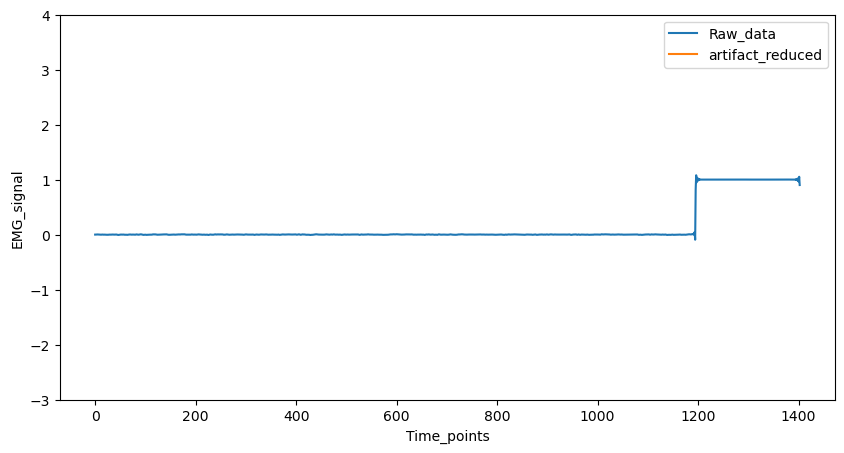

In [143]:
#plot the raw and the corrected veriosn
plt.figure(figsize = (10,5))
plt.xlabel("Time_points")
plt.ylabel("EMG_signal")
plt.ylim(-3, 4)
plt.plot(pData["1_10"].Raw[46], linewidth = 1.5, label="Raw_data") #the whole trial
plt.plot(pData["1_10"].TS_arts_1[46], linewidth = 1.5, label="artifact_reduced") #the whole trial
plt.legend()

# Now we can plot and save the filtered data

In [ ]:
# save_flag=1
# subject_plots_folder_name=subject+'_plots'
# save_folder = os.path.join(data_folder,subject_plots_folder_name,"Arts_2_complete")
# os.makedirs(save_folder,exist_ok=True)

In [ ]:
time_series_key='TS_arts_2'
time_points_key='Time_points_arts_2'
init_t_plot = 0
end_t_plot = -1

In [ ]:
###Plot all the graphs
#to run set run =1
run=1
if run ==1:
    list_elecs = df_subject_no_empty['Elec_config'].unique()
    n_list_elecs = len(list_elecs)
    for i_elec in range(n_list_elecs):
        elec_i = list_elecs[i_elec]
        df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
        df_subject_no_empty_elec_i.dropna(inplace=True)
        list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
        n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
        for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
            muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
            df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
            df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
            plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)

# Organize the data

In [ ]:
###Save every index of df subject into an object ###

#to run data set run=1
run=0

class DfSubject:
    def __init__(self, idx):
        self.idx=idx
        self.Trial_number= df_subject.loc[df_subject.index==self.idx]["Trial_number"]
        self.Raw= df_subject.loc[df_subject.index==self.idx]["Raw"]
        self.Time_points= df_subject.loc[df_subject.index==self.idx]["Time_points"]
        self.Muscle_or_other= df_subject.loc[df_subject.index==self.idx]["Muscle_or_other"]
        self.Elec_config= df_subject.loc[df_subject.index==self.idx]["Elec_config"]
        self.Subject= df_subject.loc[df_subject.index==self.idx]["Subject"]
        self.Amplitudes= df_subject.loc[df_subject.index==self.idx]["Amplitudes"]
    
    

if run ==1:
    #make a list where index is automatically incorporated into _index_#
    number_to_str=[]
    for number in range (0, len(df_subject)):
        number=number="_"+str(number)+"_"
        number_to_str.append(number)
    
    #Create dic where every index is an object # acess data like this:  pData["_123_"].Raw
    i=0
    pData = {}
    for number in number_to_str:
        pData[number] = DfSubject(i)
        i+=1
    
    
#_0_, _1_, etc.
#Upload the data to pickle file and save files in masterthesis folder #


#Example object
#_1_=DfSubject(1) #print(_1_.Raw)


In [ ]:
### save files as pickle file  to projectome_finder#
#to run set run=1
run=1
if run == 1:
    import pickle
    fh = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/Class2_dump.pkl', "wb")
    pickle.dump(pData, fh)
    fh.close()

In [ ]:
### retrieve  dfSubject structured as pData  #
#run the structure of the data before opening the pickle (wihtout creating an object)
# command pData["_0_"].Trial_number=0
import pickle
with open('DATA_Dump.pkl', 'rb') as handle:
    pData = pickle.load(handle)


Data of patientM012...
You chose to see a specific Electrode:
you chose Nr.5 and this is the LVLat muscle
<class 'int'>
type of electrode <class 'int'>
n_trials_elec_i_muscle_i:130
We are printing Raw


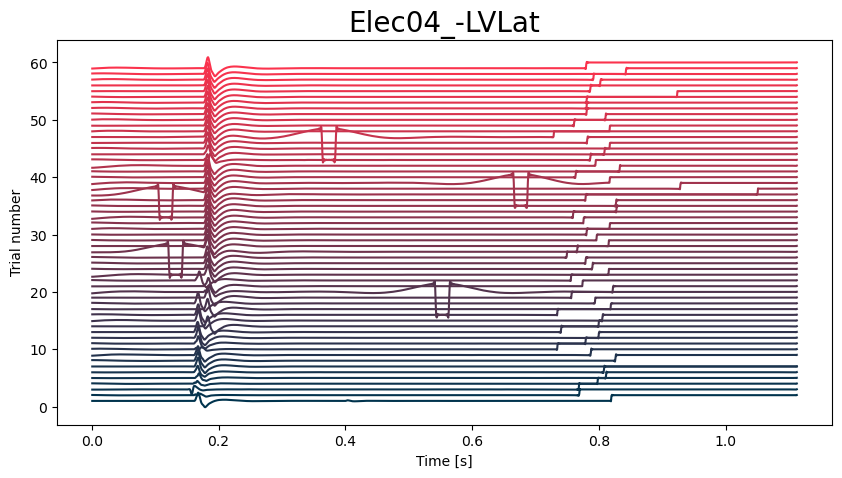

In [ ]:

### Plot a specific muslce and electrode

class EMG_Data_Dic:
    def __init__(self, patient):
        self.patient=patient
        print(f"Data of patient{self.patient}...")
        # self.print_muscle()

    def print_muscle(self):
        print("You chose to see a specific muscle")
        global list_muscle_or_other_elec_i
        muscle_number=int(input(f"(Which muscle do you want to look at? For LST press 0, for RST 1 etc {list_muscle_or_other_elec_i[0:-1]}")) # choose a muscle
        muscle_chosen=list_muscle_or_other_elec_i[muscle_number]
        print(f"you chose Nr.{muscle_number} and this is the {muscle_chosen} muscle")
        
        answer= str(input("Do you want all Electrodes? of that muscle (y/n"))
        if answer == "y":
            list_elecs = df_subject_no_empty['Elec_config'].unique()
            n_list_elecs = len(list_elecs)
            for i_elec in range(n_list_elecs):
                elec_i = list_elecs[i_elec]
                df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
                df_subject_no_empty_elec_i.dropna(inplace=True)
                list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
                n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
          
                muscle_i_elec_i = list_muscle_or_other_elec_i[muscle_number]
                df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
                df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
                plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)
        else:
            self.elec_number= int(input(f"Which electrode do you want press nr to choose: 0 for Elec01, 1 for Elec02 etc.  {elec_names}"))
            #Now output the graphs 
            list_elecs = df_subject_no_empty['Elec_config'].unique()
            n_list_elecs = len(list_elecs)
            elec_i = list_elecs[self.elec_number]
            df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
            df_subject_no_empty_elec_i.dropna(inplace=True)
            list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
            n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
            muscle_i_elec_i = list_muscle_or_other_elec_i[muscle_number]
            df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
            df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
            plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)

    def print_Electrode(self):
        print("You chose to see a specific Electrode:")
        global list_muscle_or_other_elec_i, list_elecs
        self.elec_number= int(input(f"Which electrode do you want press nr to choose: {elec_names}"))
        answer=str(input("Do you want all muscles?(y/n)"))
        if answer == "y":
            elec_i = list_elecs[self.elec_number]
            df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
            df_subject_no_empty_elec_i.dropna(inplace=True)
            list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
            n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
            for i_muscle_or_other_elec_i in range(n_muscle_or_other_elec_i):
                muscle_i_elec_i = list_muscle_or_other_elec_i[i_muscle_or_other_elec_i]
                df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
                df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
                print(f"n_trials_elec_i_muscle_i:{n_trials_elec_i_muscle_i}")
                plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)
                
        else:    
            muscle_number=int(input(f"(Which muscle do you want to look at? For LST press 0, for RST 1 etc {list_muscle_or_other_elec_i[0:-1]}")) #input for muscle number
            muscle_chosen=list_muscle_or_other_elec_i[muscle_number] #
            print(f"you chose Nr.{muscle_number} and this is the {muscle_chosen} muscle")
            print(type(muscle_number))
            print(f"type of electrode {type(self.elec_number)}")
            print(df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
            #Now output the graphs 
            list_elecs = df_subject_no_empty['Elec_config'].unique()
            n_list_elecs = len(list_elecs)

            elec_i = list_elecs[self.elec_number]
            df_subject_no_empty_elec_i = df_subject_no_empty.where(df_subject_no_empty['Elec_config']==elec_i)
            df_subject_no_empty_elec_i.dropna(inplace=True)
            list_muscle_or_other_elec_i = df_subject_no_empty_elec_i['Muscle_or_other'].unique()
            n_muscle_or_other_elec_i = len(list_muscle_or_other_elec_i)
            muscle_i_elec_i = list_muscle_or_other_elec_i[muscle_number]
            df_subject_no_empty_elec_i_muscle_i = df_subject_no_empty_elec_i.where(df_subject_no_empty_elec_i['Muscle_or_other']==muscle_i_elec_i)
            df_subject_no_empty_elec_i_muscle_i.dropna(inplace=True)
            print(f"n_trials_elec_i_muscle_i:{n_trials_elec_i_muscle_i}")
            plot_trial_elec_i_muscle_i(df_subject_no_empty_elec_i_muscle_i,elec_i=elec_i, muscle_i_elec_i=muscle_i_elec_i, time_series_key=time_series_key,time_points_key=time_points_key,init_t_plot =init_t_plot ,end_t_plot =end_t_plot ,save_flag=save_flag,save_folder=save_folder)


   


# x=EMG_Data_Dic("M012")
# x.print_Electrode()  
# x.print_muscle()  

# Plots

## Single plots

## Raw EMGs multiplots

## Filter and plot the enveloppe

## Plot the envelope of the filtered signal without the artefacts